This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict the closing stock price of AAPL. We will do this using the past 60 day price.

In [48]:
# importing libraries

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [49]:
# getting the stock quote and putting it into a dataframe
df = web.DataReader('AAPL', data_source='stooq', start='2012-01-01', end='2023-10-18')
# reverse the dataframe
df = df.iloc[::-1]
# showing the data
df

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,12.4779,12.5577,12.4520,12.5198,3.544907e+08
2012-01-04,12.4849,12.6235,12.4600,12.5866,3.051786e+08
2012-01-05,12.6314,12.7422,12.5627,12.7272,3.178972e+08
2012-01-06,12.7800,12.8717,12.7630,12.8608,3.734286e+08
2012-01-09,12.9525,13.0213,12.8289,12.8408,4.620092e+08
...,...,...,...,...,...
2023-10-12,180.0700,182.3400,179.0400,180.7100,5.674312e+07
2023-10-13,181.4200,181.9300,178.1400,178.8500,5.145608e+07
2023-10-16,176.7500,179.0750,176.5100,178.7200,5.251698e+07


In [50]:
# get the number of rows and collumns in the data set
df.shape

(2968, 5)

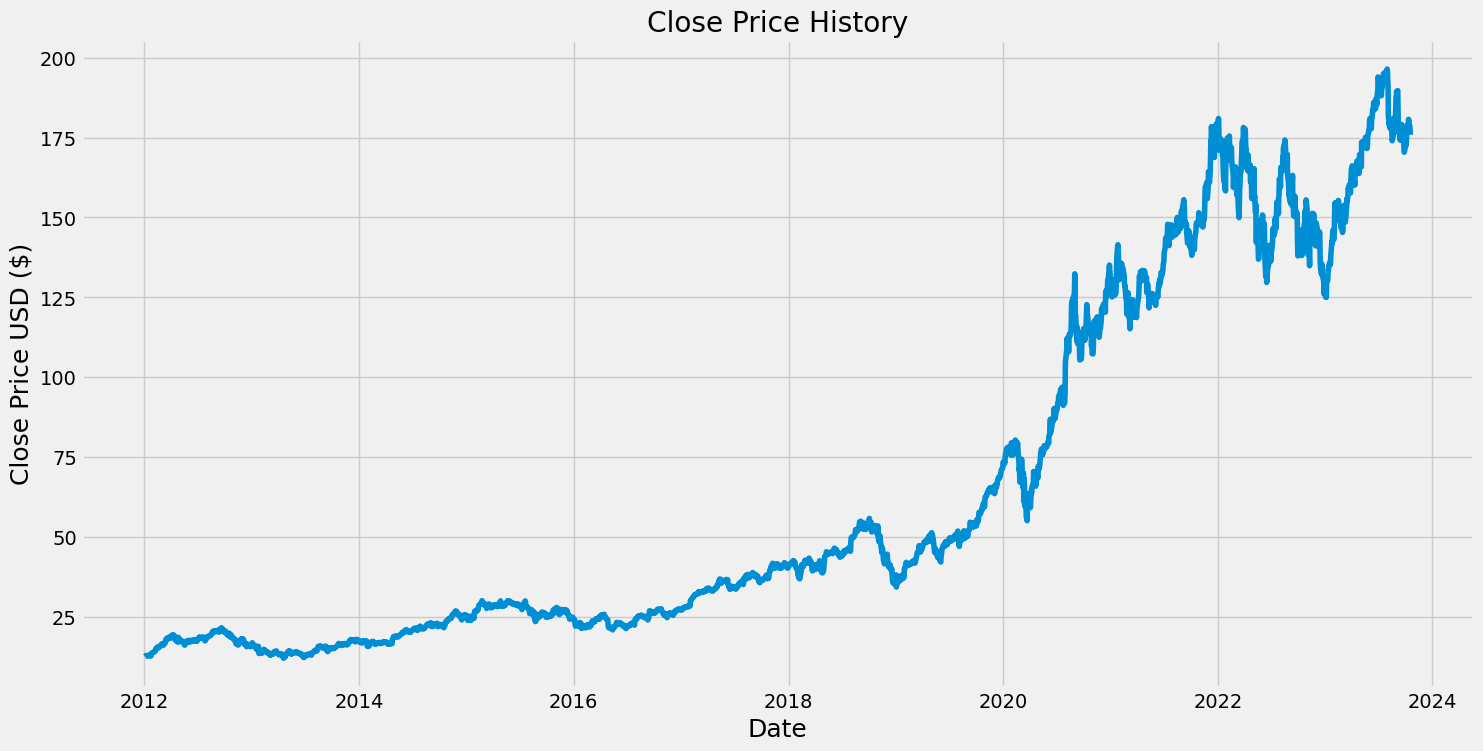

In [51]:
# visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [52]:
# create a new dataframe with only the Close column
data = df.filter(['Close'])
# convert dataframe to a numpy array
dataset = data.values
# get number of rows to train the model on (80% of all data we have)
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

2375

In [53]:
# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00247091],
       [0.00283319],
       [0.00359572],
       ...,
       [0.90384292],
       [0.89532817],
       [0.8882235 ]])

In [54]:
# create the scaled training dataset
train_data = scaled_data[0:training_data_len, :]
# split the data into x_train and y_train datasets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<= 61:
    print(x_train)
    print(y_train)
    print()

[array([0.00247091, 0.00283319, 0.00359572, 0.00432029, 0.00421182,
       0.00446076, 0.00434741, 0.00415216, 0.0038875 , 0.00467715,
       0.00541745, 0.00519075, 0.00396885, 0.00513651, 0.00398512,
       0.00831572, 0.00798597, 0.00841876, 0.00935918, 0.00994328,
       0.00989501, 0.00971604, 0.0104623 , 0.01117602, 0.01197598,
       0.0132738 , 0.01599364, 0.01603703, 0.01755612, 0.01868636,
       0.01674532, 0.01748562, 0.01746935, 0.01957309, 0.01927589,
       0.01982691, 0.02083295, 0.02138939, 0.02296869, 0.02413635,
       0.02447152, 0.02459625, 0.02259556, 0.02211396, 0.02218989,
       0.024055  , 0.02459625, 0.02570968, 0.02837529, 0.03191677,
       0.03125186, 0.03125186, 0.03381443, 0.03462034, 0.03405306,
       0.03352265, 0.0329879 , 0.0347825 , 0.03602664, 0.03654511])]
[0.03526410385181507]

[array([0.00247091, 0.00283319, 0.00359572, 0.00432029, 0.00421182,
       0.00446076, 0.00434741, 0.00415216, 0.0038875 , 0.00467715,
       0.00541745, 0.00519075, 0.00

In [55]:
# convert the x_train and y_train into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [56]:
# reshape the data
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2315, 60, 1)

In [58]:
from keras.src.layers.serialization import activation
# build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))

In [59]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [60]:
# train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2315/2315 [==============================] - 45s 18ms/step - loss: 0.0014


In [61]:
# create the testing dataset
# create a new array containing scaled values from index 2315 to 2968
test_data = scaled_data[training_data_len - 60: , :]
# create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [62]:
# convert data into a numpy array
x_test = np.array(x_test)

In [63]:
# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [64]:
# get the models predicted price data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

19/19 [==============================] - 1s 11ms/step


In [65]:
# get the root mean square error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

8.691303811131121

<ipython-input-66-c603e788247d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


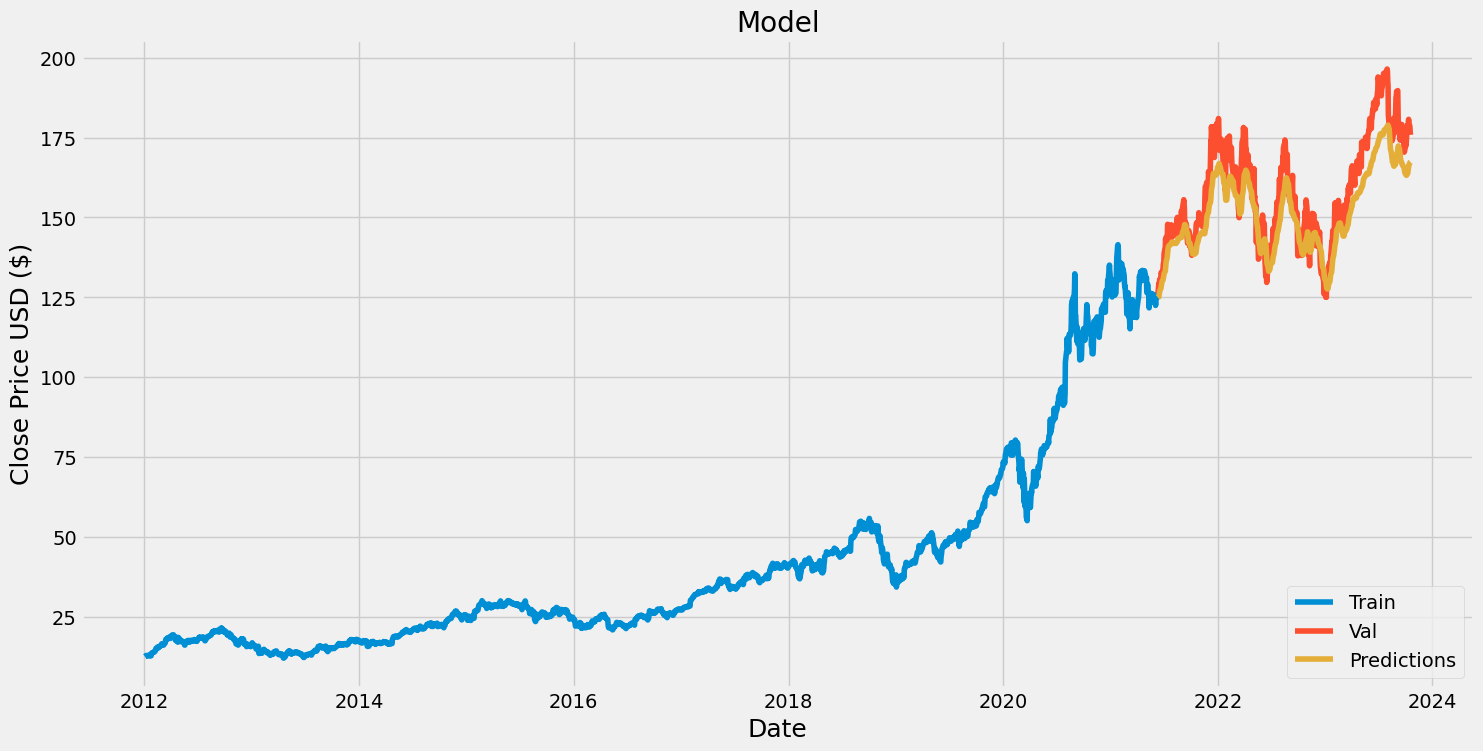

In [66]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [67]:
# show the valid prices vs the predicted ones
valid

,Close,Predictions
Date,,
2021-06-11,126.235,124.892036
2021-06-14,129.335,125.110657
2021-06-15,128.518,125.604187
2021-06-16,129.016,126.116669
2021-06-17,130.641,126.634331
...,...,...
2023-10-12,180.710,165.806030
2023-10-13,178.850,166.504288
2023-10-16,178.720,166.988556
